In [1]:
# imports

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

from report_writer import ReportWriter
from utils import get_info

In [51]:

RESULTS_FOLDER = "../results"
DATA_FOLDER = "../data"
TEMP_FOLDER = "../tmp"

FILE_URL ='https://raw.githubusercontent.com/propublica/compas-analysis/refs/heads/master/compas-scores-two-years.csv'
FILE_NAME = 'compas-scores-two-years.csv'

# file is small, i will not chunk

if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

if not os.path.exists(os.path.join(DATA_FOLDER, FILE_NAME)):
    import urllib.request
    urllib.request.urlretrieve(FILE_URL, os.path.join(DATA_FOLDER, FILE_NAME))

data_file_path = os.path.join(DATA_FOLDER, 'compas-scores-two-years.csv')
df = pd.read_csv(data_file_path)
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (7214, 53)


In [52]:

print(df['decile_score'].describe())

count    7214.000000
mean        4.509565
std         2.856396
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max        10.000000
Name: decile_score, dtype: float64


In [53]:
df_reduced = df[['sex', 'two_year_recid', 'decile_score', 'priors_count', 'age_cat', 'race', 'c_charge_degree']]





In [55]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Copy the original dataset
df_encoded = df_reduced.copy()

# onehot encoding
ohe_features = ['sex', 'race', 'c_charge_degree', 'age_cat']

ohe = OneHotEncoder()
df_ohe = pd.DataFrame(ohe.fit_transform(df_encoded[ohe_features]).toarray(), columns=ohe.get_feature_names_out(ohe_features))
df_encoded = pd.concat([df_encoded, df_ohe], axis=1)

df_final = df_encoded[['two_year_recid', 'decile_score', 'priors_count','sex_Female','race_African-American','race_Asian','race_Caucasian','race_Hispanic','race_Native American','race_Other'
                      ,'c_charge_degree_M','age_cat_Greater than 45','age_cat_Less than 25']]


#,'decile_score'

final_file_path = os.path.join(DATA_FOLDER, 'final_dataset.csv')
df_final.to_csv(final_file_path, index=False)

In [80]:
import torch

DECILE_LABEL = 'decile_score'
RECID_LABEL = 'two_year_recid'




X = df_final.drop(columns=[RECID_LABEL, DECILE_LABEL])
y = df_final[DECILE_LABEL]-1


print(y.describe())

tensor_X = torch.tensor(X.values, dtype=torch.float32)
tensor_y = torch.tensor(y.values, dtype=torch.int64)

# one hot y
tensor_y_onehot = torch.nn.functional.one_hot(tensor_y, num_classes=10)





count    7214.000000
mean        3.509565
std         2.856396
min         0.000000
25%         1.000000
50%         3.000000
75%         6.000000
max         9.000000
Name: decile_score, dtype: float64


In [70]:
from sklearn.model_selection import train_test_split


#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(tensor_X, tensor_y_onehot, test_size=0.25, shuffle=True, stratify=y, random_state=42)

print(f"Train shape: {train_x.shape}, train type: {type(train_x)}")
print(f"Validation shape: {valid_x.shape}, validation type: {type(valid_x)}")
print(f"Train target shape: {train_y.shape} train target type: {type(train_y)}")
print(f"Validation target shape: {valid_y.shape} validation target type: {type(valid_y)}")





Train shape: torch.Size([5410, 11]), train type: <class 'torch.Tensor'>
Validation shape: torch.Size([1804, 11]), validation type: <class 'torch.Tensor'>
Train target shape: torch.Size([5410, 10]) train target type: <class 'torch.Tensor'>
Validation target shape: torch.Size([1804, 10]) validation target type: <class 'torch.Tensor'>


# Neural network

In [84]:
import torch

print(f"Train shape: {train_x.shape}, train type: {type(train_x)}")
print(f"Validation shape: {valid_x.shape}, validation type: {type(valid_x)}")
print(f"Train target shape: {train_y.shape} train target type: {type(train_y)}")
print(f"Validation target shape: {valid_y.shape} validation target type: {type(valid_y)}")

X_train_tensor = torch.tensor(train_x.clone().detach(), dtype=torch.float32)
y_train_tensor = torch.tensor(train_y.clone().detach(), dtype=torch.int64)
X_val_tensor = torch.tensor(valid_x.clone().detach(), dtype=torch.float32)
y_val_tensor = torch.tensor(valid_y.clone().detach(), dtype=torch.int64)

Train shape: torch.Size([5410, 11]), train type: <class 'torch.Tensor'>
Validation shape: torch.Size([1804, 11]), validation type: <class 'torch.Tensor'>
Train target shape: torch.Size([5410, 10]) train target type: <class 'torch.Tensor'>
Validation target shape: torch.Size([1804, 10]) validation target type: <class 'torch.Tensor'>


C:\Users\carme\AppData\Local\Temp\ipykernel_11116\2709737047.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(train_x.clone().detach(), dtype=torch.float32)
C:\Users\carme\AppData\Local\Temp\ipykernel_11116\2709737047.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(train_y.clone().detach(), dtype=torch.int64)
C:\Users\carme\AppData\Local\Temp\ipykernel_11116\2709737047.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(valid_x.clone().detach()

Epoch 1/100, Loss: 0.0201
Epoch 2/100, Loss: 0.0193
Epoch 3/100, Loss: 0.0192
Epoch 4/100, Loss: 0.0191
Epoch 5/100, Loss: 0.0191
Epoch 6/100, Loss: 0.0190
Epoch 7/100, Loss: 0.0190
Epoch 8/100, Loss: 0.0190
Epoch 9/100, Loss: 0.0190
Epoch 10/100, Loss: 0.0190
Epoch 11/100, Loss: 0.0190
Epoch 12/100, Loss: 0.0190
Epoch 13/100, Loss: 0.0189
Epoch 14/100, Loss: 0.0189
Epoch 15/100, Loss: 0.0189
Epoch 16/100, Loss: 0.0189
Epoch 17/100, Loss: 0.0189
Epoch 18/100, Loss: 0.0189
Epoch 19/100, Loss: 0.0189
Epoch 20/100, Loss: 0.0189
Epoch 21/100, Loss: 0.0189
Epoch 22/100, Loss: 0.0189
Epoch 23/100, Loss: 0.0189
Epoch 24/100, Loss: 0.0189
Epoch 25/100, Loss: 0.0189
Epoch 26/100, Loss: 0.0188
Epoch 27/100, Loss: 0.0188
Epoch 28/100, Loss: 0.0188
Epoch 29/100, Loss: 0.0188
Epoch 30/100, Loss: 0.0188
Epoch 31/100, Loss: 0.0188
Epoch 32/100, Loss: 0.0188
Epoch 33/100, Loss: 0.0188
Epoch 34/100, Loss: 0.0188
Epoch 35/100, Loss: 0.0188
Epoch 36/100, Loss: 0.0188
Epoch 37/100, Loss: 0.0188
Epoch 38/1

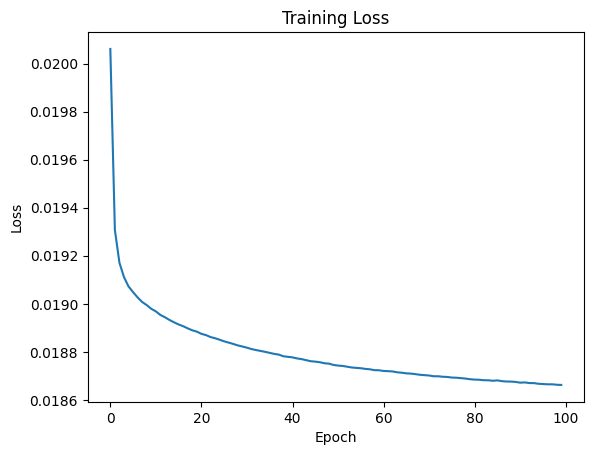

In [189]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


N_OUTPUTS = 10

# 2. Define the Neural Network
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, N_OUTPUTS)
        )

    def forward(self, x):
        return self.model(x)

input_size = train_x.shape[1]
model = BinaryClassifier(input_size)

# 3. Define the Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with Logits
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5, amsgrad=True, eps=1e-7, betas=(0.9, 0.999))

# 4. Training Loop
epochs = 100
batch_size = 32
num_samples = X_train_tensor.size(0)

losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    # Mini-batch training
    for i in range(0, num_samples, batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch).squeeze()  # Squeeze to match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss/num_samples)
    
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_samples:.4f}")

# 5. Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_dev_tensor).squeeze()
    predictions = torch.sigmoid(outputs) > 0.5  # Convert logits to probabilities and apply threshold
    accuracy = (predictions == y_dev_tensor).float().mean()

print(f"Test Accuracy: {accuracy.item():.4f}")


with torch.no_grad():
    probabilities = torch.sigmoid(model(X_train_tensor)).squeeze()
    print(probabilities[:10])  # Print the first 10 probabilities
    print(y_train_tensor[:10])  # Compare with true labels

plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()



Validation Loss: 0.6308, Validation Accuracy: 0.6669
Validation Loss: 0.6226, Validation Accuracy: 0.6619
Validation Loss: 0.6197, Validation Accuracy: 0.6619
Validation Loss: 0.6181, Validation Accuracy: 0.6624
Validation Loss: 0.6175, Validation Accuracy: 0.6657
Validation Loss: 0.6171, Validation Accuracy: 0.6624
Validation Loss: 0.6168, Validation Accuracy: 0.6630
Validation Loss: 0.6166, Validation Accuracy: 0.6635
Validation Loss: 0.6166, Validation Accuracy: 0.6630
Validation Loss: 0.6165, Validation Accuracy: 0.6641
Validation Loss: 0.6164, Validation Accuracy: 0.6646
Validation Loss: 0.6161, Validation Accuracy: 0.6646
Validation Loss: 0.6162, Validation Accuracy: 0.6663
Validation Loss: 0.6162, Validation Accuracy: 0.6674
Validation Loss: 0.6162, Validation Accuracy: 0.6663
Validation Loss: 0.6162, Validation Accuracy: 0.6657
Validation Loss: 0.6162, Validation Accuracy: 0.6669
Validation Loss: 0.6161, Validation Accuracy: 0.6669
Validation Loss: 0.6160, Validation Accuracy: 

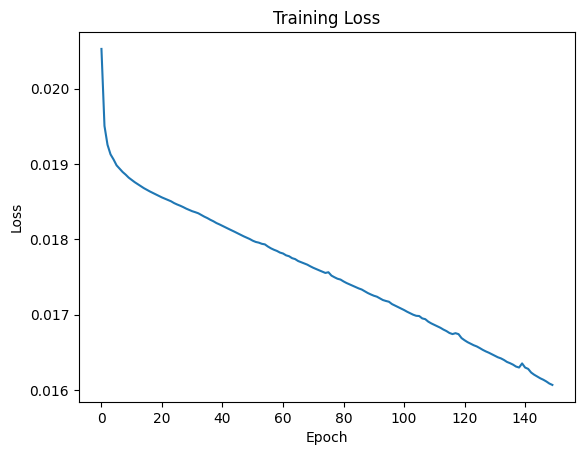

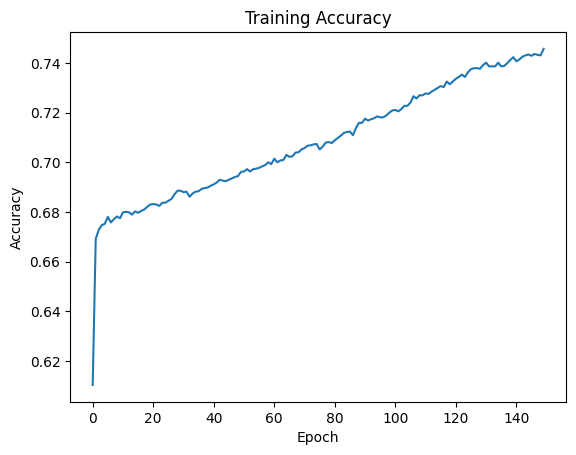

In [205]:
# 2. Define the Neural Network
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
    nn.Linear(input_size, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.LeakyReLU(),
    nn.Linear(64, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_size = train_x.shape[1]
model = BinaryClassifier(input_size)

# 3. Define the Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

# 4. Training Loop
epochs = 150
batch_size = 32
num_samples = X_train_tensor.size(0)


import torch.nn.init as init

def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)

model.apply(initialize_weights_xavier)

losses = []
accuracires = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_threshold_loss = 0.0
    correct = 0
    total = 0
    batches = 0
    incorrect = 0

    for i in range(0, num_samples, batch_size):
        
        batches += 1
        
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        logits = model(X_batch).squeeze()  # Raw logits
        # Calculate binary predictions for monitoring accuracy
        probabilities = torch.sigmoid(logits)
        predictions = probabilities > 0.5  # Apply threshold
        
        loss = criterion(logits, y_batch)
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()



        
        correct += (predictions == y_batch.int()).sum().item()
        incorrect += (predictions != y_batch.int()).sum().item()
        
        with torch.no_grad():
            loss_threshold = criterion(predictions.float(), y_batch)
            epoch_threshold_loss += loss_threshold.item()
            
    losses.append(epoch_loss/num_samples)
    accuracires.append(correct / num_samples)
    
    
    model.eval()
    with torch.no_grad():
        val_logits = model(X_dev_tensor).squeeze()
        val_loss = criterion(val_logits, y_dev_tensor)
        val_accuracy = (torch.sigmoid(val_logits) > 0.5).eq(y_dev_tensor).float().mean()
        print(f"Validation Loss: {val_loss.item():.4f}, Validation Accuracy: {val_accuracy.item():.4f}")    
    
    # # Training accuracy
    # accuracy = correct / num_samples
    # incorrect = incorrect / num_samples
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_samples:.4f}, Training Accuracy: {accuracy:.4f}, Threshold Loss: {epoch_threshold_loss/num_samples:.4f}, Batches: {batches}, Incorrect: {incorrect:.4f}", "correct: ", correct)

# 5. Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_dev_tensor).squeeze()  # Raw logits
    probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
    predictions = (probabilities > 0.5)  # Apply threshold
    accuracy = (predictions == y_dev_tensor).float().mean()  # Calculate accuracy
    print(f"Test Accuracy: {accuracy.item():.4f}")
    

with torch.no_grad():
    probabilities = torch.sigmoid(model(X_train_tensor)).squeeze()
    predictions = (probabilities > 0.5).int()  # Apply threshold
    print(predictions[:10])  # Print the first 10 probabilities
    print(y_train_tensor[:10])  # Compare with true labels
    
    
    
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(accuracires)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Logistic regression

In [150]:
# 2. Define Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # One output node for binary classification

    def forward(self, x):
        logits = self.linear(x)  # Raw logits (no sigmoid here)
        return logits

input_size = train_x.shape[1]
model = LogisticRegression(input_size)

# 3. Define the Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss with logits
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Use SGD optimizer

# 4. Training Loop
epochs = 50
batch_size = 32
num_samples = X_train_tensor.size(0)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for i in range(0, num_samples, batch_size):
        # Mini-batch preparation
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        logits = model(X_batch).squeeze()  # Raw logits
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Calculate binary predictions for accuracy
        probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
        predictions = (probabilities >= 0.5).int()  # Apply threshold
        correct += (predictions == y_batch.int()).sum().item()  # Compare predictions with ground truth
        total += y_batch.size(0)

    accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/num_samples:.4f}, Accuracy: {accuracy:.4f}")

# 5. Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_dev_tensor)  # Raw logits
    probabilities = torch.sigmoid(logits)  # Convert logits to probabilities
    predictions = (probabilities >= 0.5).int()  # Apply threshold

    # Calculate test accuracy
    accuracy = (predictions == y_dev_tensor.int()).float().mean()
    print(f"Test Accuracy: {accuracy.item():.4f}")

    # Example: Print first 10 predictions, probabilities, and ground truth
    print("Probabilities:", probabilities[:10].squeeze())
    print("Predictions:", predictions[:10].squeeze())
    print("Ground Truth:", y_dev_tensor[:10].squeeze())

Epoch 1/50, Loss: 0.0206, Accuracy: 0.6048
Epoch 2/50, Loss: 0.0202, Accuracy: 0.6344
Epoch 3/50, Loss: 0.0200, Accuracy: 0.6534
Epoch 4/50, Loss: 0.0199, Accuracy: 0.6590
Epoch 5/50, Loss: 0.0198, Accuracy: 0.6606
Epoch 6/50, Loss: 0.0197, Accuracy: 0.6621
Epoch 7/50, Loss: 0.0197, Accuracy: 0.6630
Epoch 8/50, Loss: 0.0196, Accuracy: 0.6634
Epoch 9/50, Loss: 0.0196, Accuracy: 0.6634
Epoch 10/50, Loss: 0.0196, Accuracy: 0.6647
Epoch 11/50, Loss: 0.0195, Accuracy: 0.6675
Epoch 12/50, Loss: 0.0195, Accuracy: 0.6671
Epoch 13/50, Loss: 0.0195, Accuracy: 0.6675
Epoch 14/50, Loss: 0.0195, Accuracy: 0.6682
Epoch 15/50, Loss: 0.0195, Accuracy: 0.6693
Epoch 16/50, Loss: 0.0195, Accuracy: 0.6701
Epoch 17/50, Loss: 0.0194, Accuracy: 0.6702
Epoch 18/50, Loss: 0.0194, Accuracy: 0.6706
Epoch 19/50, Loss: 0.0194, Accuracy: 0.6704
Epoch 20/50, Loss: 0.0194, Accuracy: 0.6702
Epoch 21/50, Loss: 0.0194, Accuracy: 0.6702
Epoch 22/50, Loss: 0.0194, Accuracy: 0.6695
Epoch 23/50, Loss: 0.0194, Accuracy: 0.67